In [2]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from matplotlib.colors import LogNorm

from glob import glob
import os, sys, pickle, requests
from scipy.stats import linregress
import warnings

warnings.filterwarnings("ignore")

tmp_pal=sns.color_palette('Set1',5)
standardized_palette = [tmp_pal[x] for x in [1,2,0,4,3]]\
+[[0,0,0],[128/255, 128/255,128/255],[128/255, 128/255,128/255]]# [[218/255,165/255,32/255]]

Populating the interactive namespace from numpy and matplotlib


In [33]:
df = pd.read_json('../data/datasets_with_predictions/all_packages_est_bps_11May2020.json.zip')
df_subset = pd.read_json('../data/datasets_with_predictions/subset_est_bps_11May2020.json.zip')


In [34]:
packages=['vienna_1','vienna_2','vienna_2_nodangles','vienna_2_60C',
          'vienna_langdon_pars','vienna_rnasoft_pars',
'nupack_99','nupack_99_nodangles','nupack_95','nupack_95_nodangles','rnastructure',
'rnastructure_nocoax','contrafold_1','contrafold_2','contrafold_2_nc',
'rnasoft_99','rnasoft_07',
'rnasoft_blstar','rnasoft_99_nodangles','rnasoft_bl_nodangles','rnasoft_lam-cg',
'rnasoft_nom-cg','eternafold_A','eternafold_B','eternafold_C','eternafold_D',
'eternafold_E','eternafold_F','eternafold_G','cyclefold','learntofold']

package_subset = ['vienna_2', 'nupack_99', 'rnastructure','contrafold_2', 'rnasoft_blstar','eternafold_B']

package_subset_titles = ['Vienna 2','NUPACK 1999', 'RNAstructure',
                         'CONTRAfold 2', 'RNAsoft BLstar', 'EternaFold']

package_titles = ['Vienna 1', 'Vienna 2', 'Vienna 2, no dangles',
'Vienna 2, 60C', 'Vienna 2 `Langdon 2018` pars', 'Vienna 2 `RNASoft 2007` pars',
'NUPACK 1995', 'NUPACK 1995, no dangles', 'NUPACK 1999', 'NUPACK 1999, no dangles',
'RNAstructure', 'RNAstructure, no coaxial stacking',
'CONTRAfold 1', 'CONTRAfold 2', 'CONTRAfold 2, noncomplementary',  
'RNAsoft 1999', 'RNAsoft 1999, no dangles', 'RNAsoft 2007',
'RNAsoft BLstar', 'RNAsoft BL, no dangles', 'RNAsoft LAM-CG', 'RNAsoft NOM-CG',
'EternaFold_SRR', 'EternaFold_SCRR','EternaFold_S','EternaFold_SR','EternaFold_SC','EternaFold_C','EternaFold_R','CycleFold','LearnToFold']

package_types = [x.split('_') for x in packages]

for pkg in packages:
    df['log_pij_%s' % pkg] = -1*np.log(1e-13+df['kfold_est_bp_%s' % pkg])
for pkg in package_subset:
    df_subset['log_pij_%s' % pkg] = -1*np.log(1e-13+df_subset['kfold_est_bp_%s' % pkg])

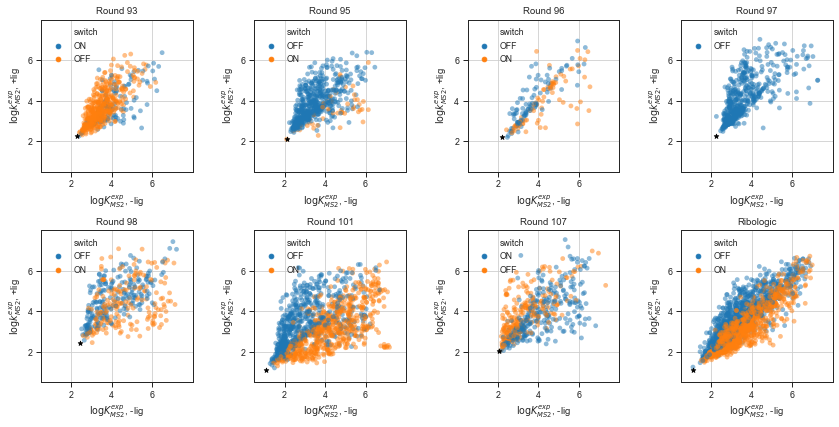

In [30]:
round_order = [93,95,96,97,98,101,107,'Ribologic']

figure(figsize=(12,6))
for i, rnd in enumerate(round_order):
    tmp_df = df_subset.loc[df_subset['Round']==rnd]
    subplot(2,4,i+1,aspect='equal')
    if rnd != 'Ribologic':
        title('Round %s' % rnd)
    else:
        title('Ribologic')
    sns.scatterplot(x='logkd_nolig',y='logkd_lig',hue='switch',data=tmp_df,linewidth=0,alpha=0.5)
    xlabel(r'$\log K_{MS2}^{exp}$, -lig')
    ylabel(r'$\log k_{MS2}^{exp}$, +lig')
    xlim([0.5,8])
    ylim([0.5,8])
    xticks([2,4,6])
    yticks([2,4,6])
    legend(frameon=False, loc='upper left')

    scatter(tmp_df['min_kd_val'].unique(),tmp_df['min_kd_val'].unique(),marker='*',color='k')
    grid()
    
tight_layout()
savefig('../figures/EternaBench_summary_KMS2_on_off.png', dpi=150, bbox_inches='tight',transparent=True)

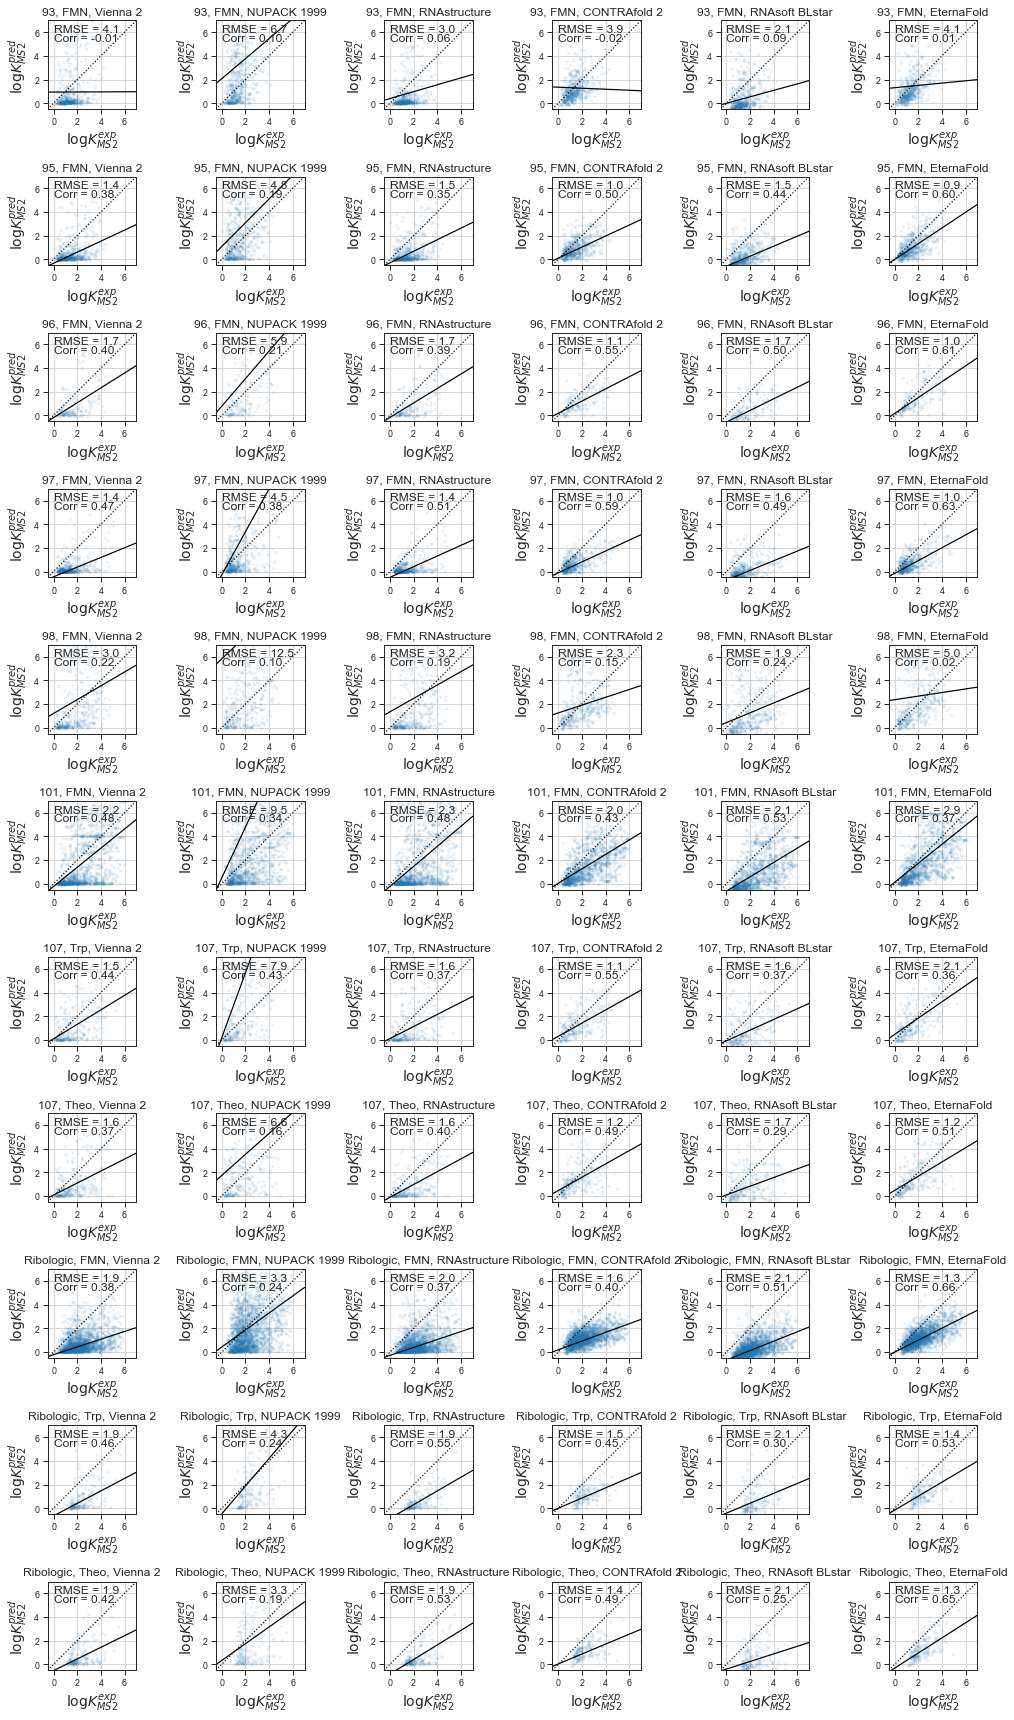

In [36]:
figure(figsize=(14,24))
ctr=1
xmin=-0.5
for j, rnd in enumerate([93, 95, 96, 97, 98, 101, 107,'Ribologic']):
    for lig in df_subset['ligand'].unique():
        tmp_df = df_subset.loc[df_subset['Round']==rnd][df_subset['ligand']==lig]
        if len(tmp_df) > 0:

            for i, pkg in enumerate(package_subset):
                subplot(11,6,ctr,aspect='equal')
                sns.scatterplot(x='logkd_nolig_scaled',y='log_pij_%s' % pkg, data=tmp_df, alpha=0.1, linewidth=0, s=10)
                x=tmp_df['logkd_nolig_scaled']
                y=tmp_df['log_pij_%s' % pkg]
                m, b = np.poly1d(np.polyfit(x, y, 1))
                rmse = np.sqrt(np.mean(np.square(x-y)))
                corr = np.corrcoef(x,y)[0][1]
                #m, _, _, _ = np.linalg.lstsq(x.values.reshape(-1,1), y.values.reshape(-1,1))
                text(0,6,"RMSE = %.1f" % rmse,fontsize=12)
                text(0,5.25,"Corr = %.2f" % corr,fontsize=12)

                plot([xmin,7],[xmin+b,7*m+b],c='k')
                plot([xmin,7],[xmin,7],linestyle=':',c='k')

                xlabel(r'$\log K_{MS2}^{exp}$',fontsize=14)
                ylabel(r'$\log K_{MS2}^{pred}$',fontsize=14)
                title("%s, %s, %s" % (rnd, lig, package_subset_titles[i]),fontsize=12)
                xlim([xmin,7])
                ylim([xmin,7])
                xticks([0,2,4,6])
                yticks([0,2,4,6])
                grid()
                ctr +=1
        
tight_layout()
savefig('../figures/eterna_rounds_package_subset.png', dpi=150, bbox_inches='tight')

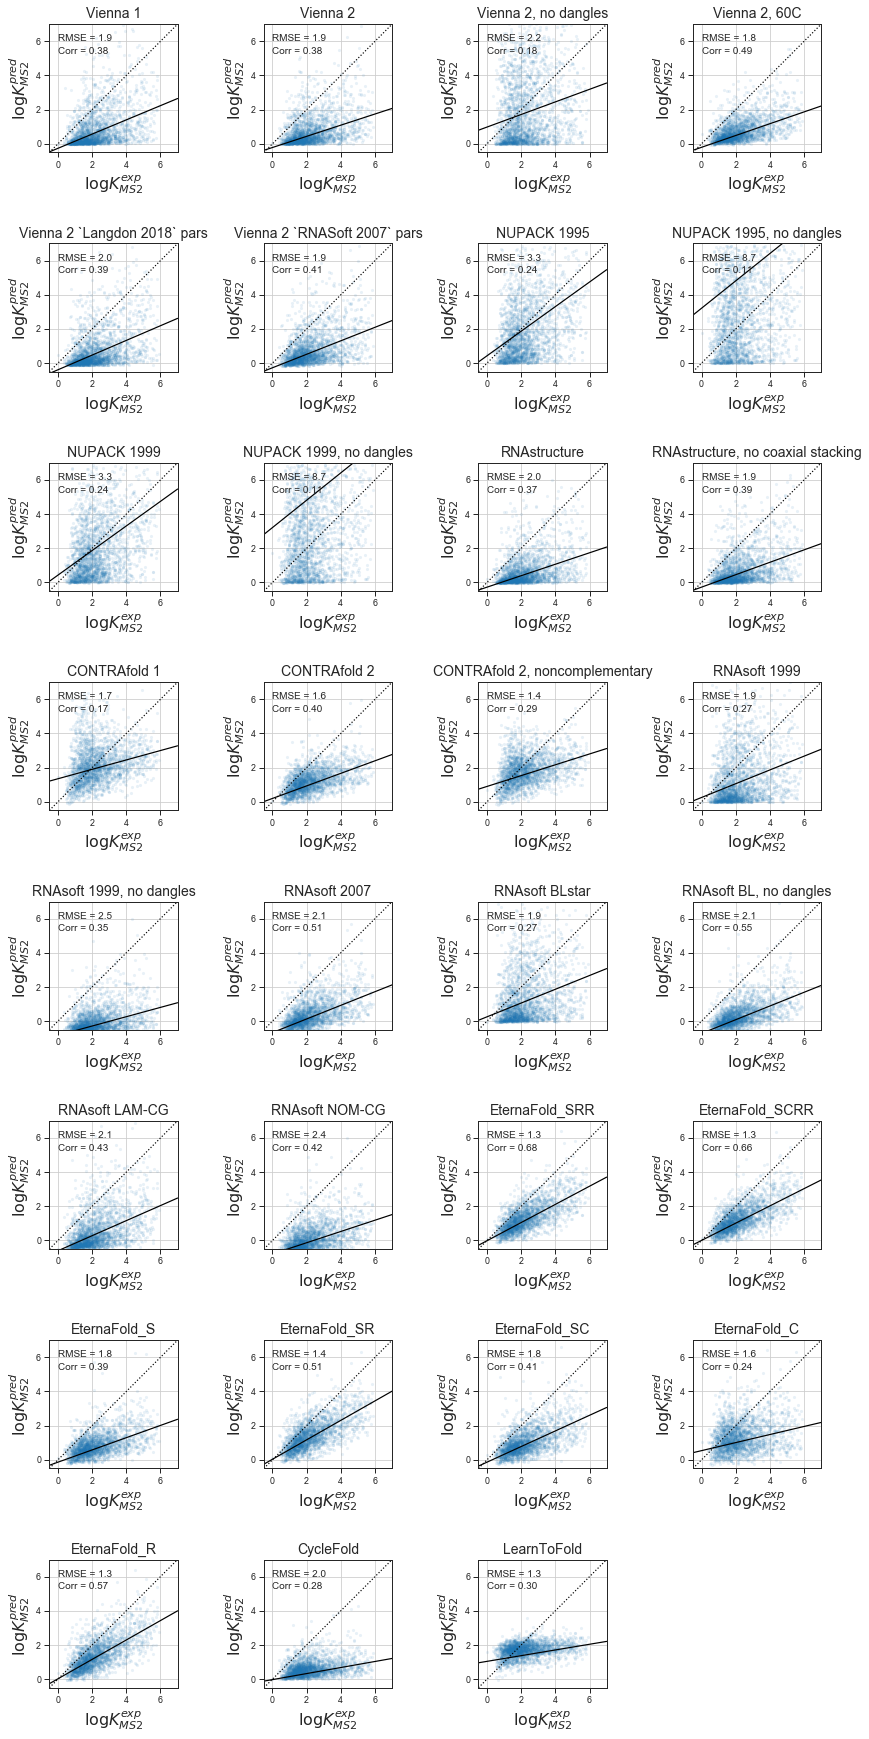

In [35]:
figure(figsize=(12,30))

xmin=-0.5
for i, pkg in enumerate(packages):

    subplot(10,4,i+1,aspect='equal')
    sns.scatterplot(x='logkd_nolig_scaled',y='log_pij_%s' % pkg, data=df, alpha=0.1, linewidth=0, s=10)
    x=df['logkd_nolig_scaled']
    y=df['log_pij_%s' % pkg]
    rmse = np.sqrt(np.mean(np.square(x-y)))
    corr = np.corrcoef(x,y)[0][1]
    m, b = np.poly1d(np.polyfit(x, y, 1))
    #m, _, _, _ = np.linalg.lstsq(x.values.reshape(-1,1), y.values.reshape(-1,1))

    plot([xmin,7],[xmin+b,7*m+b],c='k')
    plot([xmin,7],[xmin,7],linestyle=':',c='k')

    xlabel(r'$\log K_{MS2}^{exp}$',fontsize=16)
    ylabel(r'$\log K_{MS2}^{pred}$',fontsize=16)
    title(package_titles[i],fontsize=14)
    text(0,6,"RMSE = %.1f" % rmse)
    text(0,5.25,"Corr = %.2f" % corr)
    
    xlim([xmin,7])
    ylim([xmin,7])
    xticks([0,2,4,6])
    yticks([0,2,4,6])
    grid()
    
tight_layout()
savefig('../figures/ribologic_all_options_scatterplot_bps.png', dpi=150, bbox_inches='tight')

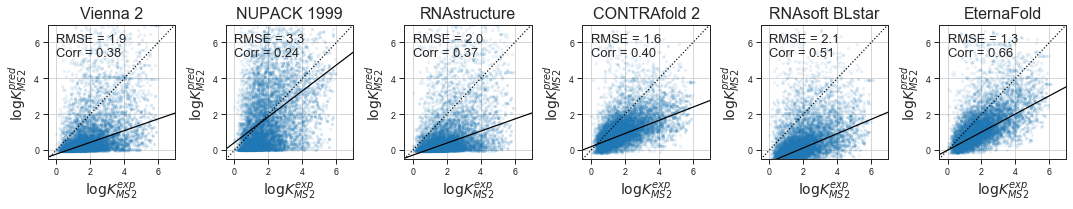

In [73]:
figure(figsize=(15,3))

xmin=-0.5
for i, pkg in enumerate(package_subset):

    subplot(1,6,i+1)
    sns.scatterplot(x='logkd_nolig_scaled',y='log_pij_%s' % pkg, data=df_subset, alpha=0.1, linewidth=0, s=10)
    x=tmp_df['logkd_nolig_scaled']
    y=tmp_df['log_pij_%s' % pkg]
    m, b = np.poly1d(np.polyfit(x, y, 1))
    rmse = np.sqrt(np.mean(np.square(x-y)))
    corr = np.corrcoef(x,y)[0][1]
    #m, _, _, _ = np.linalg.lstsq(x.values.reshape(-1,1), y.values.reshape(-1,1))
    text(0,6,"RMSE = %.1f" % rmse,fontsize=13)
    text(0,5.25,"Corr = %.2f" % corr,fontsize=13)
    
    plot([xmin,7],[xmin+b,7*m+b],c='k')
    plot([xmin,7],[xmin,7],linestyle=':',c='k')

    xlabel(r'$\log K_{MS2}^{exp}$',fontsize=14)
    ylabel(r'$\log K_{MS2}^{pred}$',fontsize=14)
    title(package_subset_titles[i],fontsize=16)
    xlim([xmin,7])
    ylim([xmin,7])
    xticks([0,2,4,6])
    yticks([0,2,4,6])
    grid()
tight_layout()
savefig('../figures/maintext_ribologic_package_subset.png', dpi=450, bbox_inches='tight')

In [11]:
def bootstrap_inds(len_item):
    return np.random.choice(range(len_item), len_item)

def compute_rmse(x_data='logkd_nolig_scaled', y_data='log_pij', df=None, package_list=None, n_bootstraps = 100):
    linreg_df = pd.DataFrame(columns=['package','rmse','C'])
    for pkg in package_list:
        for _ in range(n_bootstraps):
            bs_inds = bootstrap_inds(len(df))
            
            x = np.array([df[x_data].iloc[i] for i in bs_inds])
            y = np.array([df['%s_%s' % (y_data, pkg)].iloc[i] for i in bs_inds])
            C = np.corrcoef(x, y)[0][1]
            rmse = np.sqrt(np.mean(np.square(x-y)))
            
            linreg_df = linreg_df.append({'package': pkg, 'package_type': pkg.split('_')[0],
                                          'C': C, 'rmse': rmse}, ignore_index=True)
    return linreg_df

linreg_df = pd.DataFrame()
for rnd in df['Round'].unique():
    for lig in df['ligand'].unique():
        tmp_df = df.loc[df['Round']==rnd][df['ligand']==lig]
        
        if len(tmp_df) > 1: # only do if there exists data for this round and ligand combination
            tmp = compute_rmse(df = tmp_df, package_list = packages)
            if rnd != 'Ribologic': rnd='R %d' % rnd

            tmp['Dataset'] = "%s, %s" % (rnd, lig)
            linreg_df = linreg_df.append(tmp,ignore_index=True)

In [16]:
linreg_df_subset = pd.DataFrame()
for rnd in df_subset['Round'].unique():
    for lig in df_subset['ligand'].unique():
        tmp_df = df_subset.loc[df_subset['Round']==rnd][df_subset['ligand']==lig]
        if len(tmp_df) > 0: # only do if there exists data for this round and ligand combination
            print( rnd,lig,len(tmp_df))
            tmp = compute_rmse(df = tmp_df, package_list = package_subset,n_bootstraps=100)
            if rnd != 'Ribologic':
                tmp['Dataset'] = "R %s, %s" % (rnd, lig)
            else:
                tmp['Dataset'] = "%s, %s" % (rnd, lig)
            tmp['n_datapoints'] = len(tmp_df)
            tmp['stddev_logkd_nolig'] = np.std(tmp_df['logkd_nolig'])

            linreg_df_subset = linreg_df_subset.append(tmp,ignore_index=True)

93 FMN 545
95 FMN 573
96 FMN 166
97 FMN 505
98 FMN 410
101 FMN 1299
107 Trp 259
107 Theo 268
Ribologic FMN 2202
Ribologic Trp 183
Ribologic Theo 196


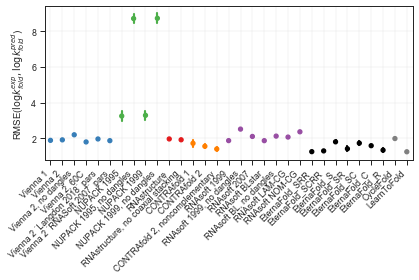

In [12]:
figure(figsize=(6,4))

ax = sns.pointplot(x='package',y='rmse', order=packages, data=linreg_df, hue='package_type',  join=False,
        ci='sd', marker='.', scale=0.75, dodge=False,  palette=standardized_palette)
xticks(rotation=45,horizontalalignment='right')
ax.set_xticklabels(package_titles)
grid(linewidth=0.2)
ylabel(r'RMSE($\log k_{fold}^{exp}, \log k_{fold}^{pred}$)')
legend([], frameon=False)
xlabel('')

tight_layout()

savefig('../figures/RMSE_all_packages_ribologic.pdf',bbox_inches='tight',transparent=True)

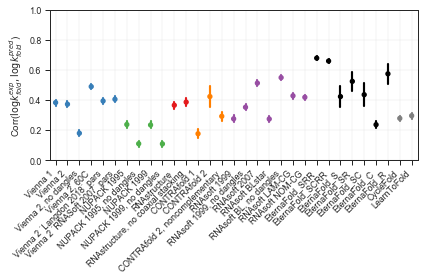

In [13]:
figure(figsize=(6,4))

ax = sns.pointplot(x='package',y='C', order=packages, data=linreg_df, hue='package_type',  join=False,
        ci='sd', marker='.', scale=0.75, dodge=False,  palette=standardized_palette)
ylabel(r'Corr($\log k_{fold}^{exp}, \log k_{fold}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
ax.set_xticklabels(package_titles)
grid(linewidth=0.2)
xlabel('')
ylim([0,1])

legend([], frameon=False)
tight_layout()
savefig('../figures/Corr_all_packages_ribologic.pdf',bbox_inches='tight',transparent=True)

In [14]:
linreg_df.to_json('bp_estimation_stats.json')
mean_stats = linreg_df.groupby(['package','Dataset'],as_index=False)['C','rmse'].mean()
var_stats = linreg_df.groupby(['package','Dataset'],as_index=False)['C','rmse'].var()
mean_stats['C_SE'] = np.sqrt(var_stats['C'])
mean_stats['rmse_SE'] = np.sqrt(var_stats['rmse'])
mean_stats.to_excel('bp_estimation_stats.xlsx')

In [17]:
linreg_df_subset.to_json('bp_estimation_stats_subset.json')
mean_stats = linreg_df_subset.groupby(['package','Dataset'],as_index=False)['C','rmse'].mean()
var_stats = linreg_df_subset.groupby(['package','Dataset'],as_index=False)['C','rmse'].var()
mean_stats['C_SE'] = np.sqrt(var_stats['C'])
mean_stats['rmse_SE'] = np.sqrt(var_stats['rmse'])
mean_stats.to_excel('bp_estimation_stats_subset.xlsx')

In [37]:
from scipy.stats import ttest_ind

def get_pairwise_significance(corr_df, metric='C', package_list = None):

    sort_order = ['vienna', 'nupack','rnastructure','contrafold','rnasoft','eternafold','cyclefold','learntofold']
    #corr_df['package_type'] = corr_df.apply(lambda row: row['package'].split('_')[0], axis=1)

    new_cdf = pd.DataFrame()
    
    for pkg in sort_order:
        tmp_df = corr_df.loc[corr_df['package_type']==pkg]
        new_cdf = new_cdf.append(tmp_df, ignore_index = True)
        
    corr_df = new_cdf
    
    if not package_list:
        package_list = corr_df['package'].unique()
        
    pval_matrix = np.zeros([len(package_list),len(package_list)])
            
    for i, pkg_1 in enumerate(package_list):
        for j, pkg_2 in enumerate(package_list[i+1:]):
            stat, pval = ttest_ind(corr_df.loc[corr_df['package']==pkg_1][metric],
                  corr_df.loc[corr_df['package']==pkg_2][metric], equal_var=False)
            
            mean1=np.mean(corr_df.loc[corr_df['package']==pkg_1][metric])
            mean2=np.mean(corr_df.loc[corr_df['package']==pkg_2][metric])
            if pval < 0.05:
                if mean1 > mean2:
                    pval_matrix[i,j+i+1] += 1
                    pval_matrix[j+i+1,i] -= 1

                else:
                    pval_matrix[i,j+i+1] -= 1        
                    pval_matrix[j+i+1,i] += 1

            if pval < 0.01:
                if mean1 > mean2:
                    pval_matrix[i,j+i+1] += 1
                    pval_matrix[j+i+1,i] -= 1

                else:
                    pval_matrix[i,j+i+1] -= 1
                    pval_matrix[j+i+1,i] += 1
                    
    if metric=='C':
        cmap='seismic'
    elif metric=='rmse':
        cmap='seismic_r'
    imshow(pval_matrix,cmap=cmap, origin='lower',vmin=-3,vmax=3)
    xticks([x for x in range(len(package_list))], package_list, rotation=45, horizontalalignment='right')
    yticks([x for x in range(len(package_list))], package_list)

    plot([-0.5,len(package_list)-0.5],[-0.5,len(package_list)-0.5],color='k')

    xlabel('Package A')
    ylabel('Package B')

    return pval_matrix

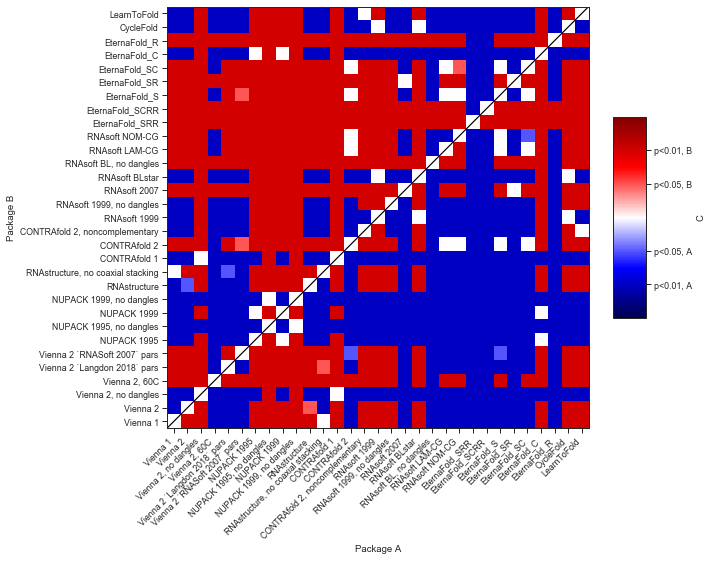

In [20]:
figure(figsize=(10,10))

mat = get_pairwise_significance(linreg_df,package_list=packages)
xticks([x for x in range(len(packages))], package_titles)
yticks([x for x in range(len(packages))], package_titles)

tight_layout()
savefig('../figures/pvals_bp_all_ribologic.pdf', bbox_inches='tight')

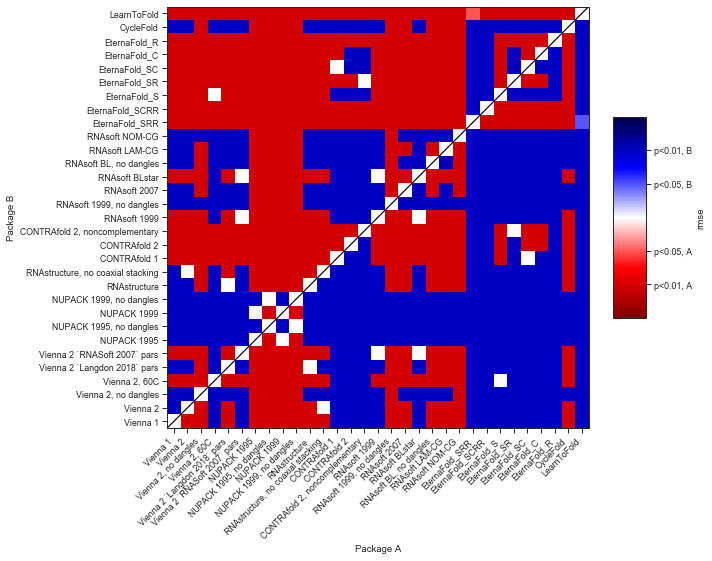

In [21]:
figure(figsize=(10,10))

mat = get_pairwise_significance(linreg_df,metric='rmse',package_list=packages)
xticks([x for x in range(len(packages))], package_titles)
yticks([x for x in range(len(packages))], package_titles)

tight_layout()
savefig('../figures/pvals_bp_rmse_all_ribologic.pdf', bbox_inches='tight')

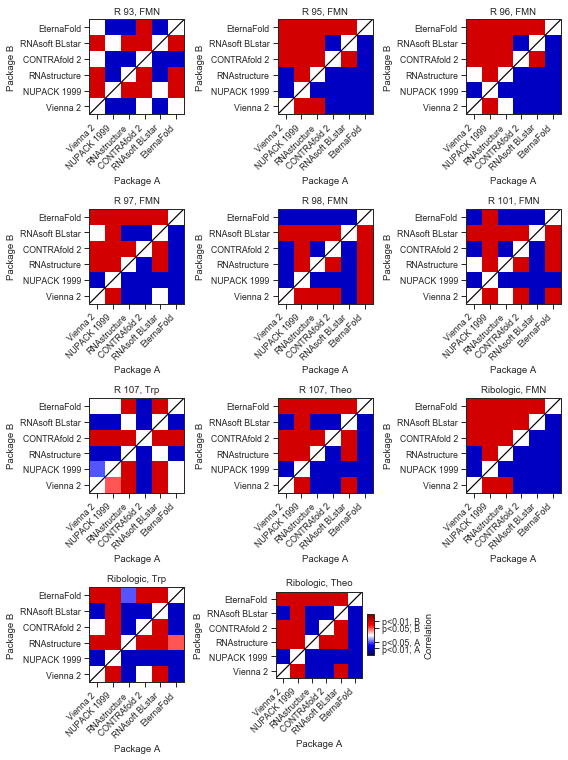

In [44]:
figure(figsize=(8,10.666))
for i, dataset in enumerate(linreg_df_subset['Dataset'].unique()):
    subplot(4,3,i+1)
    mat = get_pairwise_significance(linreg_df_subset.loc[linreg_df_subset['Dataset']==dataset],package_list=package_subset)
    title(dataset)
    
    xticks([x for x in range(6)], package_subset_titles)
    yticks([x for x in range(6)], package_subset_titles)
    
subplot(4,3,11)
cbar = colorbar(fraction=0.07, aspect=6)
cbar.set_ticks([-2,-1,1,2])
cbar.set_ticklabels(['p<0.01, A','p<0.05, A','p<0.05, B','p<0.01, B'])
cbar.set_label('Correlation')

tight_layout()
savefig('../figures/pvals_bp_all_correlation.pdf', bbox_inches='tight')

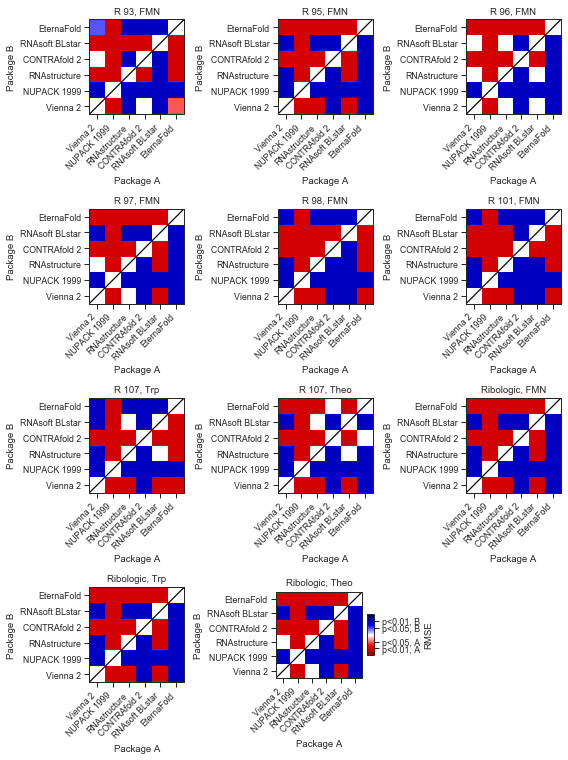

In [47]:
figure(figsize=(8,10.666))
for i, dataset in enumerate(linreg_df_subset['Dataset'].unique()):
    subplot(4,3,i+1)
    mat = get_pairwise_significance(linreg_df_subset.loc[linreg_df_subset['Dataset']==dataset], metric='rmse', package_list=package_subset)
    title(dataset)
    
    xticks([x for x in range(6)], package_subset_titles)
    yticks([x for x in range(6)], package_subset_titles)
    
subplot(4,3,11)
cbar = colorbar(fraction=0.07, aspect=6)
cbar.set_ticks([-2,-1,1,2])
cbar.set_ticklabels(['p<0.01, A','p<0.05, A','p<0.05, B','p<0.01, B'])
cbar.set_label('RMSE')

tight_layout()
savefig('../figures/pvals_bp_rmse_all.pdf', bbox_inches='tight')

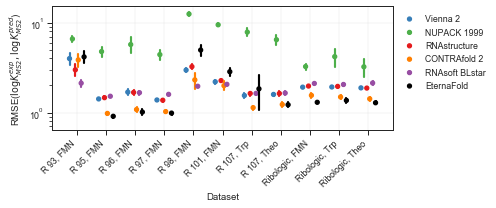

In [24]:
figure(figsize=(7,3))


ax = sns.pointplot(x='Dataset', y='rmse', hue_order=package_subset, data=linreg_df_subset,
                 hue='package', join=False, ci='sd', marker='.', scale=0.75, dodge=0.5, palette=standardized_palette)
ylabel(r'RMSE($\log K_{MS2}^{exp}, \log K_{MS2}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
semilogy()
grid(linewidth=0.2)
legend(bbox_to_anchor=(1,1), frameon=False)
leg = ax.get_legend()
for t, l in zip(leg.texts, package_subset_titles): t.set_text(l)

tight_layout()
savefig('../figures/RMSE_all_rounds_subset+eternafold.pdf',bbox_inches='tight',transparent=True)

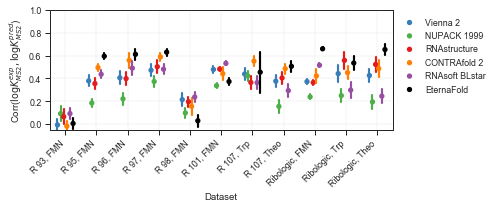

In [25]:
figure(figsize=(7,3))


ax = sns.pointplot(x='Dataset', y='C', hue_order=package_subset, data=linreg_df_subset,
                 hue='package', join=False, ci='sd', marker='.', scale=0.75, dodge=0.5, palette=standardized_palette)
ylabel(r'Corr($\log K_{MS2}^{exp}, \log K_{MS2}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
ylim([-0.05,1])
grid(linewidth=0.2)
legend(bbox_to_anchor=(1,1), frameon=False)
leg = ax.get_legend()
for t, l in zip(leg.texts, package_subset_titles): t.set_text(l)

tight_layout()
savefig('../figures/C_all_rounds_subset+eternafold.pdf',bbox_inches='tight',transparent=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


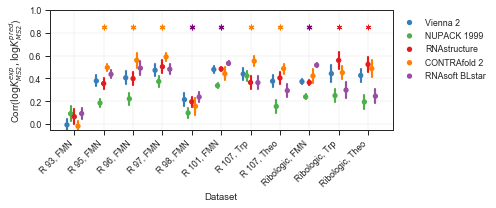

In [26]:
figure(figsize=(7,3))


ax = sns.pointplot(x='Dataset', y='C', hue_order=package_subset[:-1], data=linreg_df_subset,
                 hue='package', join=False, ci='sd', marker='.', scale=0.75, dodge=0.5, palette=standardized_palette)
ylabel(r'Corr($\log K_{MS2}^{exp}, \log K_{MS2}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
ylim([-0.05,1])
grid(linewidth=0.2)
legend(bbox_to_anchor=(1,1), frameon=False)
leg = ax.get_legend()
for t, l in zip(leg.texts, package_subset_titles[:-1]): t.set_text(l)
scatter([1,2,3,6,7],[0.85]*5,c=standardized_palette[3],marker=(6,2,0))

scatter([4,5,8],[0.85]*3,c='purple',marker=(6,2,0))
scatter([9,10],[0.85]*2,c=standardized_palette[2],marker=(6,2,0),linewidth=1)

tight_layout()
savefig('../figures/C_all_rounds_subset-eternafold.pdf',bbox_inches='tight',transparent=True)

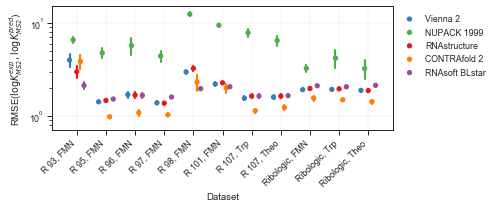

In [27]:
figure(figsize=(7,3))


ax = sns.pointplot(x='Dataset', y='rmse', hue_order=package_subset[:-1], data=linreg_df_subset,
                 hue='package', join=False, ci='sd', marker='.', scale=0.75, dodge=0.5, palette=standardized_palette)
ylabel(r'RMSE($\log K_{MS2}^{exp}, \log K_{MS2}^{pred}$)')
xticks(rotation=45,horizontalalignment='right')
semilogy()
grid(linewidth=0.2)
legend(bbox_to_anchor=(1,1), frameon=False)

leg = ax.get_legend()
for t, l in zip(leg.texts, package_subset_titles[:-1]): t.set_text(l)

tight_layout()
savefig('../figures/RMSE_all_rounds_subset-eternafold.pdf',bbox_inches='tight',transparent=True)

# check if base pair and Z estimation are the same

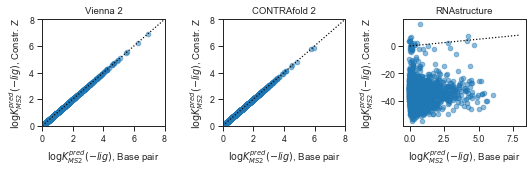

In [29]:
bp_df = pd.read_json('../data/datasets_with_predictions/all_packages_est_bps_11May2020.json.zip')
Z_df = pd.read_json('../data/datasets_with_predictions/all_packages_est_Z_11May2020.json.zip')

bp_df = bp_df.loc[bp_df['Round']=='Ribologic'][bp_df['ligand']=='FMN']
Z_df = Z_df.loc[Z_df['Round']=='Ribologic'][Z_df['ligand']=='FMN']

packages=['vienna_2','contrafold_2','rnastructure']

for pkg in packages:
    bp_df['log_pij_%s' % pkg] = -1*np.log(1e-13+bp_df['kfold_est_bp_%s' % pkg])
    
titles=['Vienna 2','CONTRAfold 2','RNAstructure',]
figure(figsize=(7.5,2.5))
for i,pkg in enumerate(packages):
    subplot(1,3,i+1)
    scatter(bp_df['log_pij_%s' % pkg], Z_df['log_kfold_est_nolig_Z_%s' % pkg],alpha=0.5)
    xlabel(r'$\log K_{MS2}^{pred}(-lig)$, Base pair')
    ylabel(r'$\log K_{MS2}^{pred}(-lig)$, Constr. Z')
    plot([0,8],[0,8],color='k',linestyle=':')
    title(titles[i])
    if i!=2:
        xlim([0,8])
        ylim([0,8])
tight_layout()
savefig('../figures/compare_bp_Z_estimation.pdf',bbox_inches='tight')